# Intro

Fix a previous script for Lind to do the lat-lon range within their specifications.

Why did Lind pick the section that they did?
- hotspot of Arctic warming
- largest reductions in winter sea-ice concentration in the Arctic in the 2000s
- this was ice covered for most of the observational record
- stable from 1970--2011 and not afterwards
- this is a circle because they had the most data coverage for the 1970--2016 period

# import the packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

<Figure size 800x500 with 0 Axes>

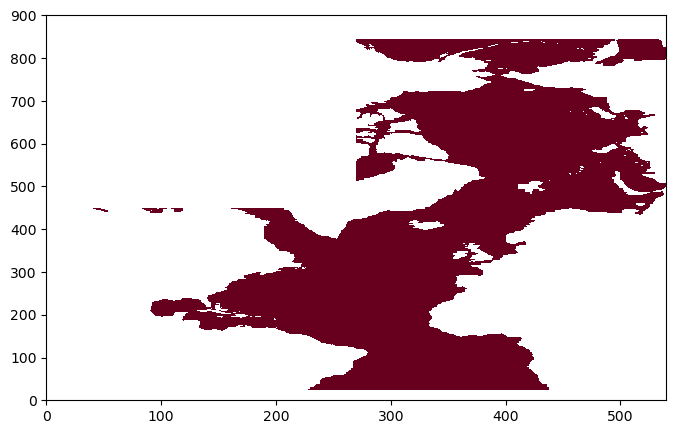

In [5]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

In [6]:
hfC[hfC<1] = np.nan

# get the files and define the mask

In [7]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [8]:
mymsk = np.load('/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/mask_Lind.npz')
mymsk = mymsk['msk1']
msk1 = mymsk

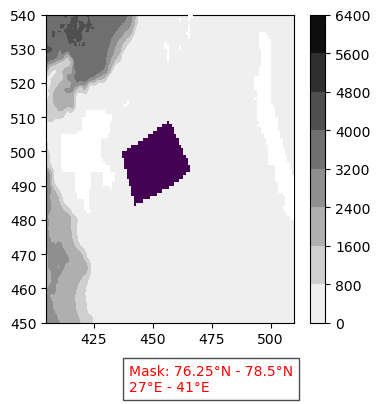

In [9]:
a = np.full(mskBasin.shape,np.nan)
# a[525:555:,35:55] = 1

# create the mask based on lat long
lon = mygrid['XC']
lat = mygrid['YC']
mask = np.zeros_like(lat)
mask[(lat >= 76.25) & (lat <= 78.5) & (lon >= 27) & (lon <= 41)] = 1  # Masked region
mask[mask == 0 ] = np.nan



fig = plt.figure(figsize=(4,4))

# cb = plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",vmin=0,vmax=300)
cb = plt.contourf(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r")
plt.colorbar(cb)

plt.pcolormesh(get_aste_tracer(mask,nfx,nfy)[0],zorder=2)
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],zorder=4,cmap="gray_r")

plt.text(440, 430, "Mask: 76.25°N - 78.5°N\n27°E - 41°E", color="red", fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'),zorder=10)

plt.xlim(405,510)
plt.ylim(450,540)

plt.savefig("figs/Lind_section.png",dpi=300)

In [10]:
mymsk = mask

# do the theta and salt profiles of this

In [11]:
idxS = 0
idxArW = np.arange(1,11,1)
idxAW = np.arange(11,50,1)

In [12]:
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_dist1 = np.zeros((len(allyears),12,nz))
salt_dist1 = np.zeros((len(allyears),12,nz))

# for heating and salting portion -- see if this is different
theta_dist2 = np.zeros((len(allyears),12,nz))
salt_dist2 = np.zeros((len(allyears),12,nz))

# Initialize arrays to store time series data at specified depth indices
theta_idxS = np.zeros((len(allyears), 12))  # Single depth index (idxS)
theta_idxArW = np.zeros((len(allyears), 12))  # Multiple depth indices (idxArW)
theta_idxAW = np.zeros((len(allyears), 12))  # Multiple depth indices (idxAW)

salt_idxS = np.zeros((len(allyears), 12))
salt_idxArW = np.zeros((len(allyears), 12))
salt_idxAW = np.zeros((len(allyears), 12))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETA = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALT = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETA[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx))
        SALT[i,:,:,:] = np.reshape(SALTi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETA[i]/hfC * mymsk[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_dist1[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz

        # do the depth averaging for freshwater
        thisSALT = SALT[i]/hfC * mymsk[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist1[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz

        # Extract mean values at specified depth indices
        theta_idxS[iy, i] = np.nanmean(thisTHETA[idxS, :, :])
        theta_idxArW[iy, i] = np.nanmean(thisTHETA[idxArW, :, :])
        theta_idxAW[iy, i] = np.nanmean(thisTHETA[idxAW, :, :])

        salt_idxS[iy, i] = np.nanmean(thisSALT[idxS, :, :])
        salt_idxArW[iy, i] = np.nanmean(thisSALT[idxArW, :, :])
        salt_idxAW[iy, i] = np.nanmean(thisSALT[idxAW, :, :])

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


Profiles saved to 'profiles.png'


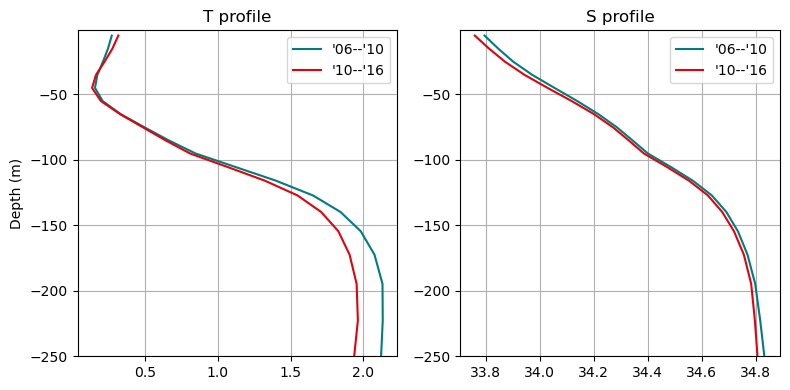

In [13]:
# colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

fig = plt.figure(figsize=(8, 4))

# First plot: Temperature profile for Southern portion
ax = plt.subplot(121)
ax.plot(np.nanmean(theta_dist1[3:8], axis=(0,1)), mygrid['RC'], label="'06--'10",color=c1)
ax.plot(np.nanmean(theta_dist1[8:-1], axis=(0,1)), mygrid['RC'], label="'10--'16",color=c3)
ax.set_ylim(-250, -1)
ax.set_title("T profile")
ax.legend()
ax.grid()
ax.set_ylabel("Depth (m)")  # Y-axis label

ax = plt.subplot(122)
# Second plot: Salinity profile for Southern portion
ax.plot(np.nanmean(salt_dist1[3:8], axis=(0,1)), mygrid['RC'], label="'06--'10",color=c1)
ax.plot(np.nanmean(salt_dist1[8:-1], axis=(0,1)), mygrid['RC'], label="'10--'16",color=c3)
ax.set_ylim(-250, -1)
ax.set_title("S profile")
ax.legend()
ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("figs/profiles_100m.png", dpi=300)

print("Profiles saved to 'profiles.png'")

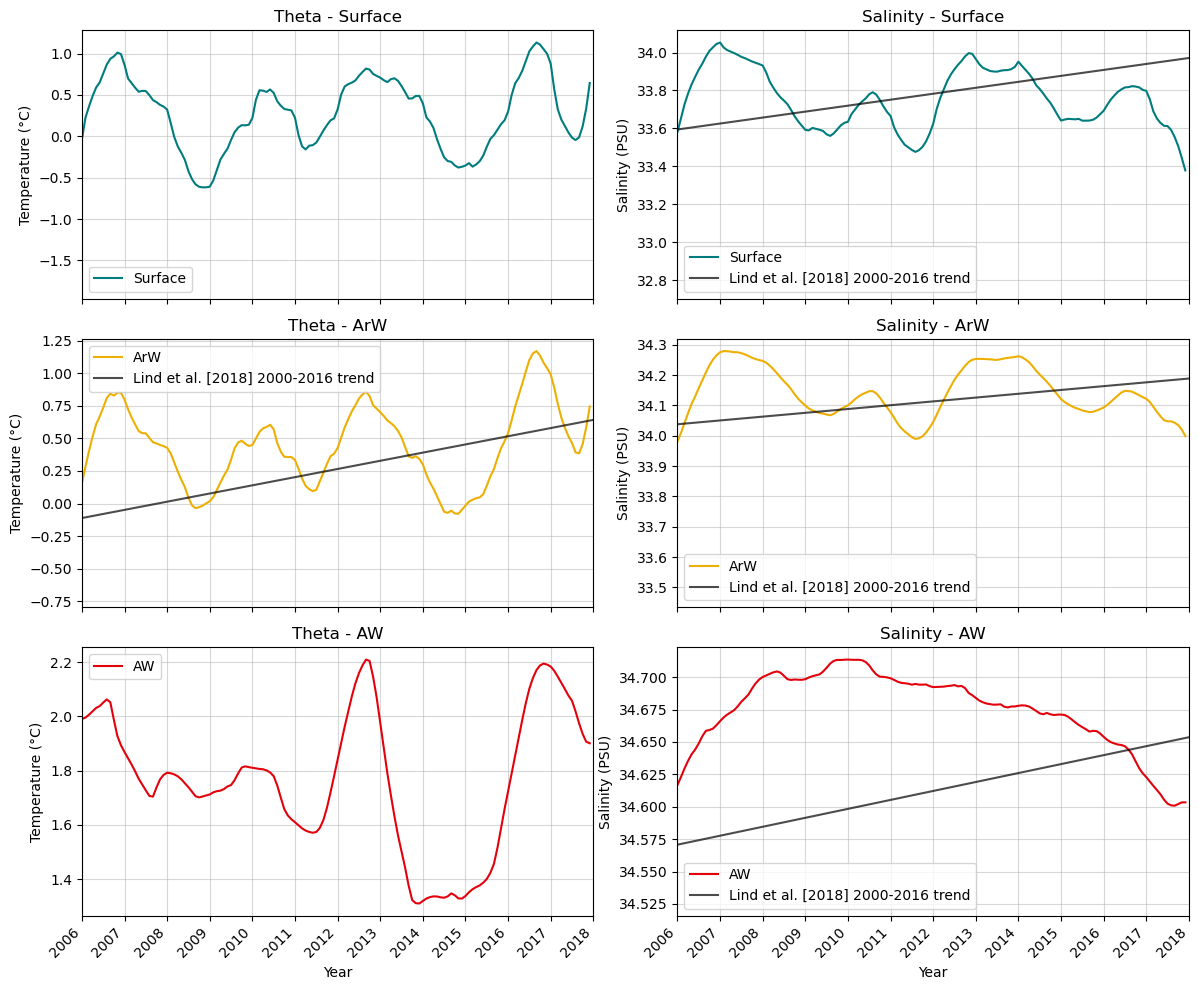

In [15]:
# Define colors
c1 = '#007c7e'  # First color
c2 = '#edaf02'  # Second color
c3 = '#e3010c'  # Third color

# Define window size for smoothing
window_size = 12  # Adjust as needed for rolling mean

# Smooth time series for theta
theta_smooth_S = pd.Series(theta_idxS.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
theta_smooth_ArW = pd.Series(theta_idxArW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
theta_smooth_AW = pd.Series(theta_idxAW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values

# Smooth time series for salt
salt_smooth_S = pd.Series(salt_idxS.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
salt_smooth_ArW = pd.Series(salt_idxArW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values
salt_smooth_AW = pd.Series(salt_idxAW.flatten()).rolling(window=window_size, center=True, min_periods=1).mean().values

# Generate time axis: Months from January 2003 onward
start_year = 2003
num_months = len(theta_smooth_S)
years = np.arange(start_year, start_year + num_months // 12 + 1, 1)
months = np.arange(num_months)
xticks = np.arange(0, num_months+1, 12)  # Yearly ticks
xticklabels = [str(year) for year in range(start_year, start_year + len(xticks))]

starti = 3*12

# Create figure with 4x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

# Plot Theta Time Series
axes[0, 0].plot(months, theta_smooth_S, label="Surface", color=c1)
axes[0, 0].set_title("Theta - Surface")
axes[0, 0].set_ylabel("Temperature (°C)")
axes[0, 0].grid(alpha=0.5)
axes[0, 0].legend()

axes[1, 0].plot(months, theta_smooth_ArW, label="ArW", color=c2)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(-.3,.7,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[1,0].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
axes[1, 0].set_title("Theta - ArW")
axes[1, 0].set_ylabel("Temperature (°C)")
axes[1, 0].grid(alpha=0.5)
axes[1, 0].legend()

axes[2, 0].plot(months, theta_smooth_AW, label="AW", color=c3)
axes[2, 0].set_title("Theta - AW")
axes[2, 0].set_ylabel("Temperature (°C)")
axes[2, 0].grid(alpha=0.5)
axes[2, 0].legend()

# Plot Salt Time Series
axes[0, 1].plot(months, salt_smooth_S, label="Surface", color=c1)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(33.5,34,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[0,1].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
axes[0, 1].set_title("Salinity - Surface")
axes[0, 1].set_ylabel("Salinity (PSU)")
axes[0, 1].grid(alpha=0.5)
axes[0, 1].legend()

axes[1, 1].plot(months, salt_smooth_ArW, label="ArW", color=c2)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(34,34.2,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[1,1].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend")
axes[1, 1].set_title("Salinity - ArW")
axes[1, 1].set_ylabel("Salinity (PSU)")
axes[1, 1].grid(alpha=0.5)
axes[1, 1].legend()

axes[2, 1].plot(months, salt_smooth_AW, label="AW", color=c3)
x_lind = np.arange(0,192) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(34.55,34.66,192)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
axes[2,1].plot(x_lind, y_lind, color="black", alpha=.7,label="Lind et al. [2018] 2000-2016 trend")
axes[2, 1].set_title("Salinity - AW")
axes[2, 1].set_ylabel("Salinity (PSU)")
axes[2, 1].grid(alpha=0.5)
axes[2, 1].legend()

# Set x-axis ticks to show years instead of months
for ax in axes[2, :]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=45,ha="right")
    ax.set_xlabel("Year")
    ax.set_xlim(starti,num_months)

# Adjust layout
plt.tight_layout()

plt.savefig("figs/Lindfig2_withcomparison_2006on.png",dpi=300)
plt.show()

# do the heat and freshwater anomalies in map view and in timeseries

In [16]:
# np.cumsum(mygrid['DRF'][0:10])
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

In [17]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10  # upper 100 m

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETA = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETA[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx)) / hfC   # degC
        SALT[i,:,:,:] = np.reshape(SALTi,(nz,ny,nx)) / hfC     # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETA[i] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)
        
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    #print()
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


# also show this in map view with the sea ice extent contour avg for 2010--2016 and 2006--2010

We want the map anomaly from 2016-2006

In [18]:
heat_content_time = np.nanmean(heat_content,axis=(2,3))
fw_content_time = np.nanmean(fw_content,axis=(2,3))

In [19]:
# Lind goes from 2000-2016 ( we will only use 2006 -- 2016)
x_lind = np.arange(-36,156) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(-180,300,192)

slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
print(slope)

x_lind = np.arange(0,15*12)
y_lind = np.linspace(180-250,630-250,15*12)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
print(slope)

2.513089005235602
2.5139664804469275


In [20]:
# Lind goes from 2000-2016 ( we will only use 2006 -- 2016)
x_lind_fw = np.arange(-36,156) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind_fw = np.linspace(2.1,1.5,192)

slope = (y_lind_fw[-1] - y_lind_fw[0]) / (x_lind_fw[-1] - x_lind_fw[0])
print(slope)

x_lind_fw = np.arange(0,15*12)
y_lind_fw = np.linspace(2.1+1.0,1.5+1.03,15*12)
slope = (y_lind_fw[-1] - y_lind_fw[0]) / (x_lind_fw[-1] - x_lind_fw[0])
print(slope)

-0.003141361256544503
-0.0031843575418994403


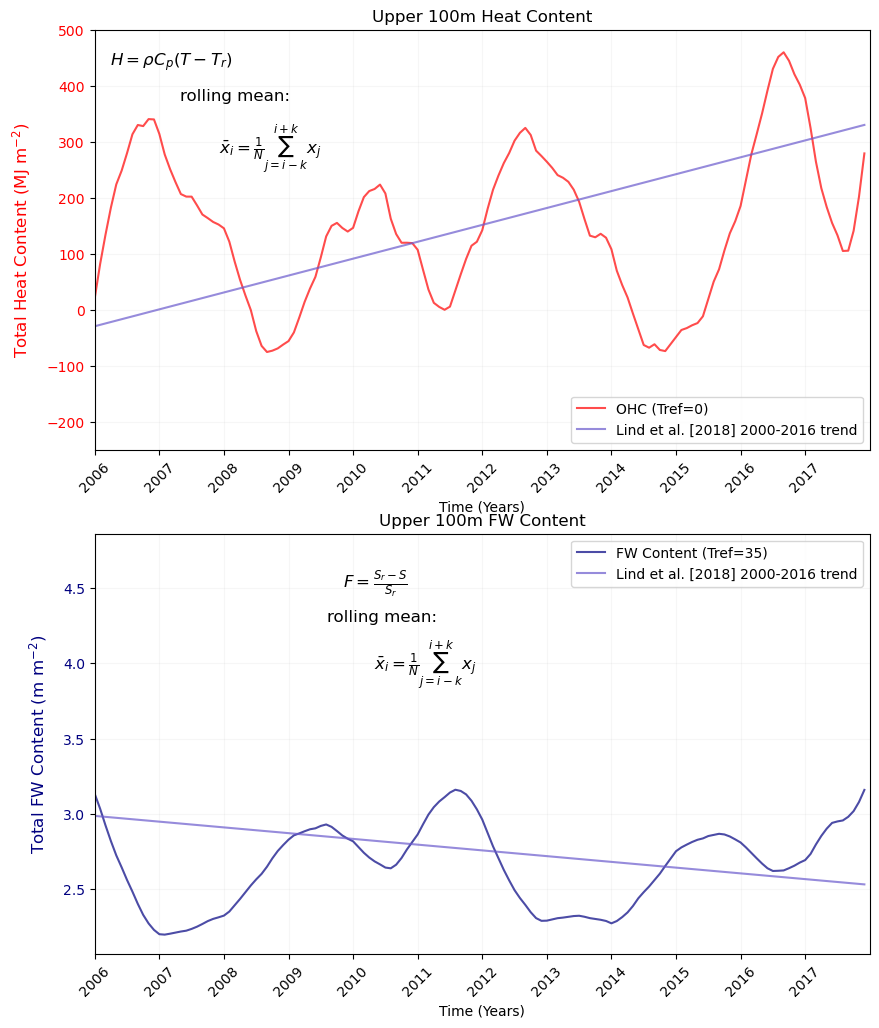

In [21]:
# remove the freshwater content and just add the heat content


# Define rolling window size (12 months for seasonal smoothing)
window_size = 12

# Apply rolling mean
heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
fw_smoothed = pd.Series(fw_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()


# Create figure and axis
fig = plt.figure(figsize=(10,12))

ax1 = plt.subplot(211)

# Time axis
time = np.arange(0, 15*12, 1)

# Plot smoothed heat content on primary y-axis (left)
ax1.plot(time, heat_smoothed, color="red", alpha=.7, label="OHC (Tref=0)")
ax1.plot(x_lind, y_lind-50, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
ax1.set_ylabel(r"Total Heat Content (MJ m$^{-2}$)", color="red", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="red")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Upper 100m Heat Content")

# X-axis ticks
xtick_positions = np.arange(0, 15*12, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 15*12)
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq2 = r"$H = \rho C_p (T - T_{r})$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
ax1.text(0.02, 0.95, eq2, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.11,0.86,"rolling mean:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.16, 0.78, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position


# Legends
ax1.legend(loc="lower right")

ax1.set_ylim(-250,500)
# ax1.set_xlim(0,time[-1])
ax1.set_xlim(3*12, 15*12)

ax1 = plt.subplot(212)


# Time axis
time = np.arange(0, 15*12, 1)

# Plot smoothed heat content on primary y-axis (left)
ax1.plot(time, fw_smoothed, color="navy", alpha=.7, label="FW Content (Tref=35)")
ax1.plot(x_lind_fw, y_lind_fw, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
# ax1.plot(x_lind, y_lind, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
ax1.set_ylabel(r"Total FW Content (m m$^{-2}$)", color="navy", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="navy")

ax1.text(0.32, 0.92, eq1, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Upper 100m FW Content")

# X-axis ticks
xtick_positions = np.arange(0, 15*12, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(3*12, 15*12)
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq2 = r"$H = \rho C_p (T - T_{r})$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
# ax1.text(0.02, 0.95, eq2, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.3,0.82,"rolling mean:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.36, 0.75, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position


# Legends
ax1.legend(loc="upper right")

# ax1.set_ylim(-250,500)


# Show plot
plt.savefig("figs/timeseries_OHC_Lind_smaller.png",dpi=300)
plt.show()

# create the map with sea ice extent

we need to make these maps without masking

In [22]:
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears),ny,nx))

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
  
    march_tsstr = tsstr[2]
    
    # read the fldList
    file_name = 'state_2d_set1'
    meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
    fldlist = np.array(meta_state_2d_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
    read = [int(tsstr[i])]
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
    SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
    SIarea = np.reshape(SIareai,(ny,nx))#*RAC  # fraction of SIarea
    
    SIareas[iy] = SIarea

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [23]:
# get the 
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10  # upper 100 m

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETA = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETA[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx)) / hfC   # degC
        SALT[i,:,:,:] = np.reshape(SALTi,(nz,ny,nx)) / hfC     # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETA[i] #* mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0)         # vertical integration (J/m^2)
        
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0)          # vertical integration, m

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    #print()
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [24]:
# maybe do only the barents sea indices for this
ys,xs = np.where(mskBasin == 6)[0],np.where(mskBasin == 6)[1]

In [32]:
# Subset years 2006–2016 (i.e., index 3:14)
hc_sub = heat_content[3:14, :, :, :]  # shape: (11, 12, ny, nx)
fw_sub = fw_content[3:14, :, :, :]    # same shape

# Reshape to (time, ny, nx) for months since 2006 January, 2016 December
hc_monthly = hc_sub.reshape(-1, ny, nx)  # shape: (132, ny, nx)
fw_monthly = fw_sub.reshape(-1, ny, nx)

# Demean x for better numerical stability (optional)
years = np.arange(132) / 12 + 2006  # shape: (132,)
x = years - years.mean()
X = np.broadcast_to(x[:, None, None], hc_monthly.shape)

# Compute means at each grid cell
Y_hc = hc_monthly
Y_fw = fw_monthly
Y_hc_mean = np.nanmean(Y_hc, axis=0)
Y_fw_mean = np.nanmean(Y_fw, axis=0)

# subtract the mean at each grid point so data is zero-centered in time
Y_hc_centered = Y_hc - Y_hc_mean
Y_fw_centered = Y_fw - Y_fw_mean

# Compute slope = cov(x, y) / var(x)
slope_heat = np.nansum(X * Y_hc_centered, axis=0) / np.nansum(X**2, axis=0)
slope_fw = np.nansum(X * Y_fw_centered, axis=0) / np.nansum(X**2, axis=0)

In [33]:
# SIareas.shape
#equation = r"$\displaystyle \text{slope}(i, j) = \frac{\sum_{t=1}^T x_t \cdot (y_t(i,j) - \bar{y}(i,j))}{\sum_{t=1}^T x_t^2}$"
# plt.text(0.02, 0.02, equation, fontsize=12, transform=plt.gca().transAxes,
#          bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

In [34]:
SI_early = np.nanmean(SIareas[3:7], axis=0)   # 2006–2009
SI_late = np.nanmean(SIareas[7:14], axis=0)   # 2010–2016

SI_early_tr = get_aste_tracer(SI_early, nfx, nfy)[0]
SI_late_tr  = get_aste_tracer(SI_late, nfx, nfy)[0]


In [35]:
mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

In [36]:
from scipy.ndimage import binary_dilation

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)


(400.0, 600.0)

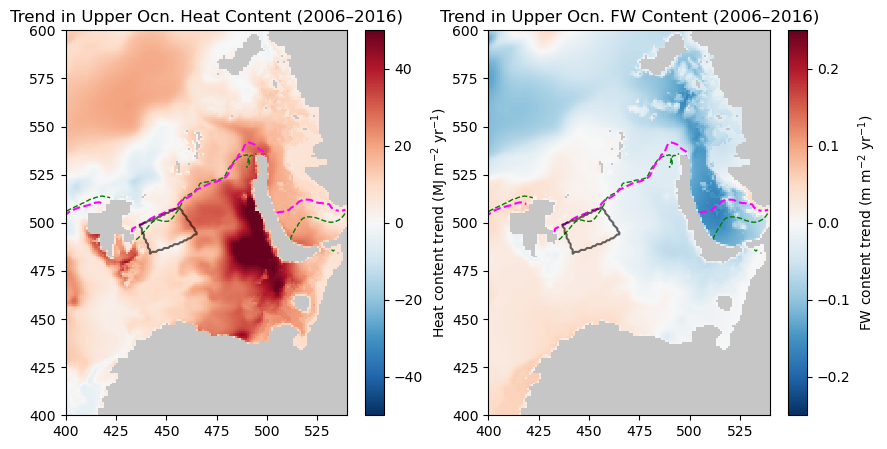

In [37]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(slope_heat,nfx,nfy)[0], cmap='RdBu_r',vmin=-50,vmax=50)
plt.colorbar(cb,label='Heat content trend (MJ m$^{-2}$ yr$^{-1}$)')
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# Add contours at SI = 0.15
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--')
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--')
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.set_title('Trend in Upper Ocn. Heat Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(slope_fw,nfx,nfy)[0], cmap='RdBu_r',vmin=-.25,vmax=.25)
plt.colorbar(cb,label='FW content trend (m m$^{-2}$ yr$^{-1}$)')
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--')
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--')
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.set_title('Trend in Upper Ocn. FW Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)

In [38]:
# Create time axis in months (centered optional but not needed here)
x = np.arange(132)  # From 0 to 131

# Broadcast to match (time, ny, nx)
X = np.broadcast_to(x[:, None, None], hc_monthly.shape)

# Compute mean of x
x_mean = np.mean(x)

# Compute mean of Y
Y_hc_mean = np.nanmean(hc_monthly, axis=0)
Y_fw_mean = np.nanmean(fw_monthly, axis=0)

# Compute slope
numerator = np.nansum((x - x_mean)[:, None, None] * (hc_monthly - Y_hc_mean), axis=0)
denominator = np.nansum((x - x_mean)**2)
slope_heat = numerator / denominator  # units: MJ/m² per month

# Now calculate predicted start and end of the linear fit
start = 0
end = 131
hc_fit_start = Y_hc_mean + slope_heat * (start - x_mean)
hc_fit_end   = Y_hc_mean + slope_heat * (end - x_mean)

# Total change = end - start (over the whole regression line)
slope_heat = hc_fit_end - hc_fit_start  # Units: MJ/m² over entire period

# Same steps for freshwater
numerator_fw = np.nansum((x - x_mean)[:, None, None] * (fw_monthly - Y_fw_mean), axis=0)
slope_fw = numerator_fw / denominator

fw_fit_start = Y_fw_mean + slope_fw * (start - x_mean)
fw_fit_end   = Y_fw_mean + slope_fw * (end - x_mean)

slope_fw = fw_fit_end - fw_fit_start  # Units: m over entire period

In [39]:
# also add the depth to this

depth_tr = get_aste_tracer(mygrid['Depth'],nfx,nfy)[0]

depth_levels = [1,100,200,300,500]

In [40]:
from matplotlib.colors import BoundaryNorm
# For slope_heat: segmented from -500 to 500 in 100 MJ/m² steps
heat_levels = np.arange(-500, 501, 30)
norm_heat = BoundaryNorm(heat_levels, ncolors=plt.get_cmap('RdBu_r').N, clip=True)

# For slope_fw: segmented from -1.5 to 1.5 in 0.3 m steps
fw_levels = np.arange(-1.5, 1.6, 0.1)
norm_fw = BoundaryNorm(fw_levels, ncolors=plt.get_cmap('RdBu_r').N, clip=True)


In [41]:
fw_levels[::3]

array([-1.50000000e+00, -1.20000000e+00, -9.00000000e-01, -6.00000000e-01,
       -3.00000000e-01,  1.33226763e-15,  3.00000000e-01,  6.00000000e-01,
        9.00000000e-01,  1.20000000e+00,  1.50000000e+00])

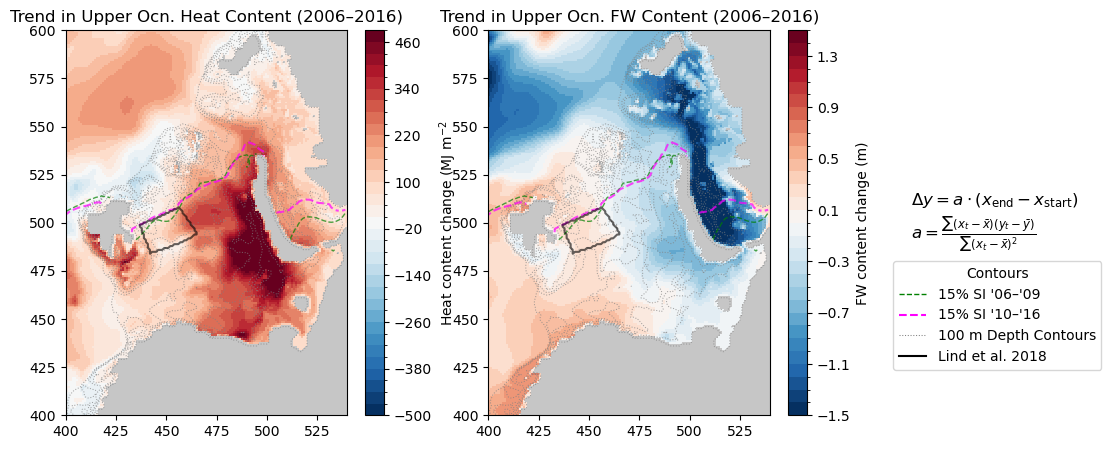

In [42]:
plt.figure(figsize=(10, 5))
from matplotlib.lines import Line2D


ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(slope_heat,nfx,nfy)[0], cmap='RdBu_r',norm=norm_heat)
plt.colorbar(cb,label='Heat content change (MJ m$^{-2}$',ticks=heat_levels[::4])
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# Add contours at SI = 0.15
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--',alpha=0.7,label="15% SI '06-'09")
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--',alpha=0.7,label="15% SI '10-'16")
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.set_title('Trend in Upper Ocn. Heat Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)
eq1 = (
    r"$\Delta y = a \cdot (x_{\mathrm{end}} - x_{\mathrm{start}})$" + "\n" +
    r"$a = \frac{\sum (x_t - \bar{x})(y_t - \bar{y})}{\sum (x_t - \bar{x})^2}$"
)
ax.text(3, 0.5, eq1,
        fontsize=12,
        transform=ax.transAxes,
        va='center',
        ha='left',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(slope_fw,nfx,nfy)[0], cmap='RdBu_r',norm=norm_fw)
plt.colorbar(cb,label='FW content change (m)',ticks=fw_levels[::4])
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--',alpha=0.7,label="15% SI '06-'09")
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--',alpha=0.7,label="15% SI '06-'09")
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.set_title('Trend in Upper Ocn. FW Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)

legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', linewidth=1, label="15% SI '06–'09"),
    Line2D([0], [0], color='magenta', linestyle='--', linewidth=1.5, label="15% SI '10–'16"),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=0.75, label='100 m Depth Contours'),
    Line2D([0], [0], color="black",linestyle='-',label="Lind et al. 2018"),
]

# Place legend to the right and downward (adjust anchor as needed)
plt.legend(handles=legend_elements,
           loc='lower right',
           bbox_to_anchor=(2.2, 0.1),
           fontsize=10,
           frameon=True,
           title='Contours')

plt.savefig("figs/heat_fw.png",dpi=300, bbox_inches='tight')

In [43]:
# we should also add to this the place of the polar front as an example from SST data

In [44]:
# get the theta and salt for all years

all_SST = np.full((len(allyears),12,ny,nx),np.nan)

iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_SST = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        thisyear_SST[i,:,:] = np.reshape(THETAi,(nz,ny,nx))[0] # just add SST

    # get theta and salt alone so we can use for the freshwater content
    all_SST[iy,:,:,:] = thisyear_SST
    
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [45]:
# get a map of the SST gradients as a timeseries
DXG = get_aste_tracer(mygrid['DXG'],nfx,nfy)[0]
DYG = get_aste_tracer(mygrid['DYG'],nfx,nfy)[0]
all_gradT = np.zeros((len(allyears),12,900,540))

for year_idx in range(15):
    for month_idx in range(12):
        # Extract year and month name
        year = allyears[year_idx]  # Extract actual year from allyears array

        # Extract data for this timestep
        SST1 = all_SST[year_idx, month_idx]  # SST for current month

        # Compute SST gradient (grad_T)
        tracerSST = get_aste_tracer(SST1,nfx,nfy)[0]
        dTdx = np.zeros_like(tracerSST)
        dTdx[:, 1:-1] = (tracerSST[:, 2:] - tracerSST[:, :-2]) / (DXG[:, 2:] + DXG[:, :-2])
        
        dTdy = np.zeros_like(get_aste_tracer(SST1,nfx,nfy)[0])
        dTdy[1:-1, :] = (tracerSST[2:, :] - tracerSST[:-2, :]) / (DYG[2:, :] + DYG[:-2, :])
        
        grad_T = np.sqrt(dTdx**2 + dTdy**2)  # Compute magnitude
        mask = (tracerSST > -2) & (tracerSST < 4)  # Mask only within PF-relevant SST range
        grad_T_masked = grad_T * mask * 1000  # Convert to °C/km

        all_gradT[year_idx,month_idx] = grad_T_masked

In [49]:
from scipy.ndimage import gaussian_filter

# Subset to years 2006–2016 (i.e., years 3:14 if starting from 2003)
gradT_avg = np.nanmean(all_gradT[3:14], axis=(0, 1))  # shape: (ny, nx)

depth = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]

landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

gradT_masked = np.where(landbuffer_tr, np.nan, gradT_avg)

lo = np.nanpercentile(gradT_masked, 91)
hi = np.nanpercentile(gradT_masked, 100)

In [50]:
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import gaussian_filter

# 1. Average and smooth SST gradient
gradT_avg = np.nanmean(all_gradT[3:14], axis=(0, 1))
# gradT_smooth = gaussian_filter(gradT_avg, sigma=2)

# 2. Apply land/ice buffer if needed
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)
gradT_smooth_masked = np.where(landbuffer_tr, np.nan, gradT_avg)

# 3. Threshold to get binary mask of frontal zone
thresh = np.nanpercentile(gradT_smooth_masked, 93)
front_mask = gradT_smooth_masked > thresh

# 4. Label connected components
labeled, num_features = label(front_mask)

# 5. Find the largest component (ignore label 0 = background)
sizes = np.bincount(labeled.ravel())
sizes[0] = 0  # ignore background
largest_label = np.argmax(sizes)

# 6. Create mask of only the largest region
largest_blob = labeled == largest_label
frontal_shape = np.where(largest_blob, 1, np.nan)  # for plotting

# Optional: mask with isobath
depth = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
isobath_mask = (depth >= 0) & (depth <= 400)
frontal_shape = np.where(isobath_mask, frontal_shape, np.nan)


In [61]:
# get the mean SST from all_SST
all_SST_avg = np.nanmean(all_SST[3:14], axis=(0,1)) # still doing up to 2016 because we're comparing to Lind here
all_SST_avg = get_aste_tracer(all_SST_avg,nfx,nfy)[0]
all_SST_avg.shape

# this needs to be masked with the land
all_SST_avg = np.where(landbuffer_tr, np.nan, all_SST_avg)

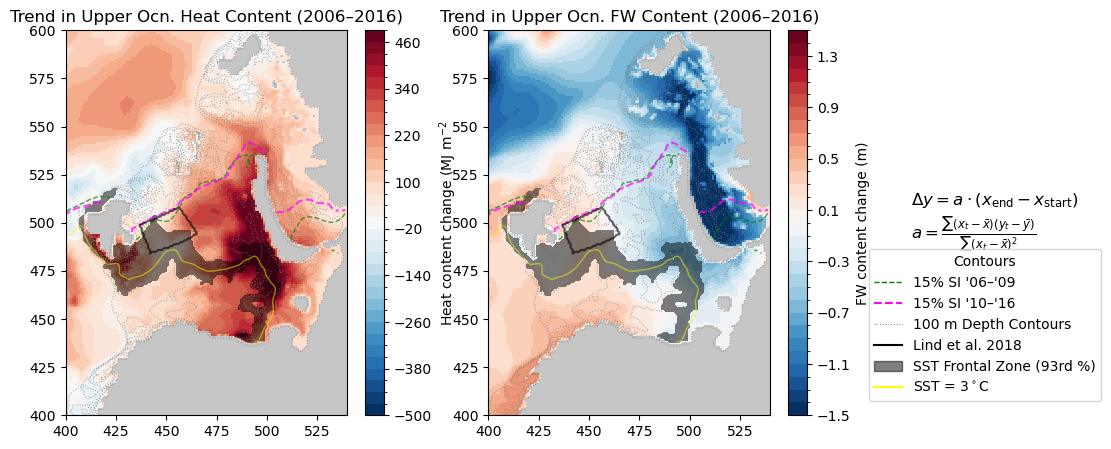

In [69]:
from matplotlib.patches import Patch

plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(slope_heat,nfx,nfy)[0], cmap='RdBu_r',norm=norm_heat)
plt.colorbar(cb,label='Heat content change (MJ m$^{-2}$',ticks=heat_levels[::4])
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# Add contours at SI = 0.15
ax.contourf(frontal_shape, levels=[0.5,1.5], colors='black', linewidths=1.2, linestyles='-', alpha=0.5)
ax.contour(all_SST_avg,levels=[3],colors='yellow',linewidths = 1,linestyles='-',alpha=0.5)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--',alpha=0.7)
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--',alpha=0.7)
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.set_title('Trend in Upper Ocn. Heat Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)
eq1 = (
    r"$\Delta y = a \cdot (x_{\mathrm{end}} - x_{\mathrm{start}})$" + "\n" +
    r"$a = \frac{\sum (x_t - \bar{x})(y_t - \bar{y})}{\sum (x_t - \bar{x})^2}$"
)
ax.text(3, 0.5, eq1,
        fontsize=12,
        transform=ax.transAxes,
        va='center',
        ha='left',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(slope_fw,nfx,nfy)[0], cmap='RdBu_r',norm=norm_fw)
plt.colorbar(cb,label='FW content change (m)',ticks=fw_levels[::4])
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax.contour(all_SST_avg,levels=[3],colors='yellow',linewidths = 1,linestyles='-',alpha=0.5)
ax.contourf(frontal_shape, levels=[0.5,1.5], colors='black', linewidths=1.2, linestyles='-', alpha=0.5)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--',alpha=0.7)
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--',alpha=0.7)
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.set_title('Trend in Upper Ocn. FW Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)

legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', linewidth=1, label="15% SI '06–'09"),
    Line2D([0], [0], color='magenta', linestyle='--', linewidth=1.5, label="15% SI '10–'16"),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=0.75, label='100 m Depth Contours'),
    Line2D([0], [0], color="black",linestyle='-',label="Lind et al. 2018"),
    Patch(facecolor='black', edgecolor='black', alpha=0.5, label='SST Frontal Zone (93rd %)'),
    Line2D([0], [0], color="yellow",linestyle='-',label="SST = 3$^\circ$C"),
]

# Place legend to the right and downward (adjust anchor as needed)
plt.legend(handles=legend_elements,
           loc='lower right',
           bbox_to_anchor=(2.2, 0.02),
           fontsize=10,
           frameon=True,
           title='Contours')

plt.savefig("figs/heat_fw_withfront.png",dpi=300, bbox_inches='tight')

# it would be nice to add the gates on here colored by if they avg inflow or outflow
# we can load the gates to add this to the plot

In [63]:
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

# x_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["ix"]-1  #3
# y_sta_vilkit = gg['StAnnaTrough/Voronin/Vilkitshogo']["jy"]-1

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3
# test[y_sta_vilkit,x_sta_vilkit] = 4

(400.0, 600.0)

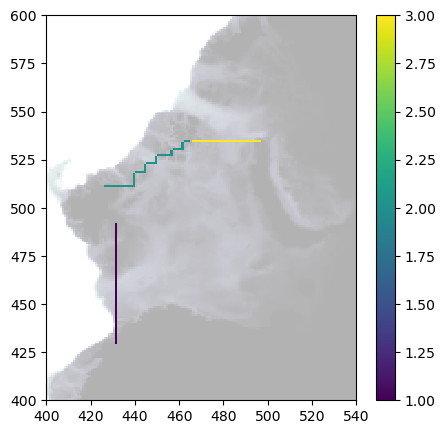

In [66]:
# get the four edges of this

# mask[mask>1]=1
xlims = np.array([400,540])
ylims = np.array([400,600])

# plot this
fig = plt.figure(figsize = (5,5))
plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="bone",alpha=0.3,vmin=0,vmax=1000)
# plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap="bone_r",zorder=5)
cb = plt.pcolormesh(get_aste_tracer(test,nfx,nfy)[0],zorder=10)
plt.colorbar(cb)
plt.xlim(xlims)
plt.ylim(ylims)

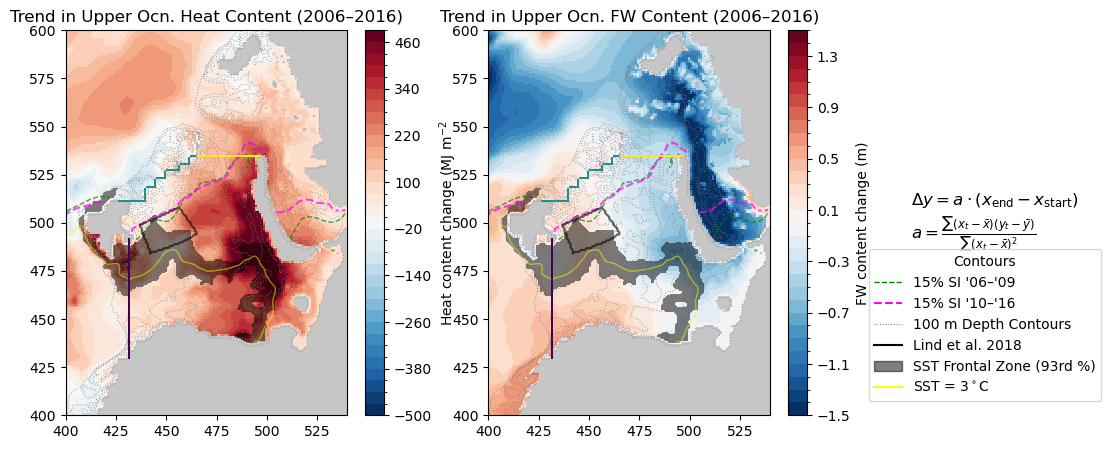

In [68]:
# I think we want to mask these depths based on the inflow and outflow of AW

# just do one with the gates

from matplotlib.patches import Patch

plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(slope_heat,nfx,nfy)[0], cmap='RdBu_r',norm=norm_heat)
plt.colorbar(cb,label='Heat content change (MJ m$^{-2}$',ticks=heat_levels[::4])
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
# Add contours at SI = 0.15
ax.contourf(frontal_shape, levels=[0.5,1.5], colors='black', linewidths=1.2, linestyles='-', alpha=0.5)
ax.contour(all_SST_avg,levels=[3],colors='yellow',linewidths = 1,linestyles='-',alpha=0.5)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--',alpha=0.7)
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--',alpha=0.7)
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.pcolormesh(get_aste_tracer(test,nfx,nfy)[0],zorder=10)
ax.set_title('Trend in Upper Ocn. Heat Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)
eq1 = (
    r"$\Delta y = a \cdot (x_{\mathrm{end}} - x_{\mathrm{start}})$" + "\n" +
    r"$a = \frac{\sum (x_t - \bar{x})(y_t - \bar{y})}{\sum (x_t - \bar{x})^2}$"
)
ax.text(3, 0.5, eq1,
        fontsize=12,
        transform=ax.transAxes,
        va='center',
        ha='left',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(slope_fw,nfx,nfy)[0], cmap='RdBu_r',norm=norm_fw)
plt.colorbar(cb,label='FW content change (m)',ticks=fw_levels[::4])
ax.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",zorder=2,vmin=0,vmax=6)
ax.contour(all_SST_avg,levels=[3],colors='yellow',linewidths = 1,linestyles='-',alpha=0.5)
ax.contourf(frontal_shape, levels=[0.5,1.5], colors='black', linewidths=1.2, linestyles='-', alpha=0.5)
ax.contour(depth_tr, levels=depth_levels, colors='gray', linewidths=0.75, linestyles=':',alpha=0.7)
ax.contour(SI_early_tr_masked, levels=[0.15], colors='green', linewidths=1, linestyles='--',alpha=0.7)
ax.contour(SI_late_tr_masked,  levels=[0.15], colors='magenta', linewidths=1.5, linestyles='--',alpha=0.7)
ax.contour(get_aste_tracer(mymsk_tr,nfx,nfy)[0],levels=[0.9],colors="black",linestypes='-',alpha=0.6)
ax.pcolormesh(get_aste_tracer(test,nfx,nfy)[0],zorder=10)
ax.set_title('Trend in Upper Ocn. FW Content (2006–2016)')
ax.set_xlim(400,540)
ax.set_ylim(400,600)

legend_elements = [
    Line2D([0], [0], color='green', linestyle='--', linewidth=1, label="15% SI '06–'09"),
    Line2D([0], [0], color='magenta', linestyle='--', linewidth=1.5, label="15% SI '10–'16"),
    Line2D([0], [0], color='gray', linestyle=':', linewidth=0.75, label='100 m Depth Contours'),
    Line2D([0], [0], color="black",linestyle='-',label="Lind et al. 2018"),
    Patch(facecolor='black', edgecolor='black', alpha=0.5, label='SST Frontal Zone (93rd %)'),
    Line2D([0], [0], color="yellow",linestyle='-',label="SST = 3$^\circ$C"),
]

# Place legend to the right and downward (adjust anchor as needed)
plt.legend(handles=legend_elements,
           loc='lower right',
           bbox_to_anchor=(2.2, 0.02),
           fontsize=10,
           frameon=True,
           title='Contours')

plt.savefig("figs/heat_fw_withfront_andgates.png",dpi=300, bbox_inches='tight')